[Global Spotify Weekly Chart](https://www.kaggle.com/datasets/kabhishm/global-spotify-weekly-chart/)

[Kmeans using Pyspark](https://www.kdnuggets.com/2023/02/pyspark-data-science.html)

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master("local[5]") \
        .appName("K-Means") \
        .getOrCreate()

spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/17 12:34:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Loading the data
df = spark.read.csv("DataFiles/spotify_weekly_chart.csv",
                    header=True,
                    sep=",")
df.printSchema()
df.show()

root
 |-- Pos: string (nullable = true)
 |-- P+: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Wks: string (nullable = true)
 |-- Pk: string (nullable = true)
 |-- (x?): string (nullable = true)
 |-- Streams: string (nullable = true)
 |-- Streams+: string (nullable = true)
 |-- Total: string (nullable = true)

+---+---+---------------+--------------------+---+---+----+--------+----------+----------+
|Pos| P+|         Artist|               Title|Wks| Pk|(x?)| Streams|  Streams+|     Total|
+---+---+---------------+--------------------+---+---+----+--------+----------+----------+
|  1|  =|   Miley Cyrus |             Flowers|  7|  1|   7|56744018|-5019054.0| 585390148|
|  2|NEW|       KAROL G |                 TQG|  1|  2|   1|53284451|      NULL|  53284451|
|  3|NEW|    The Weeknd |         Die For You|  1|  3|   1|46213370|      NULL|  46213370|
|  4| -2|           SZA |           Kill Bill| 12|  1|   2|45630547| -918530.0| 556

In [6]:
# Updating the schema
from pyspark.sql.types import StructField, IntegerType, StringType, DoubleType, StructType

data_schema = [
    StructField("Pos", IntegerType(), True),
    StructField("P+", StringType(), True),
    StructField("Artist", StringType(), True),
    StructField("Title", StringType(), True),
    StructField("Wks", IntegerType(), True),
    StructField("Pk", IntegerType(), True),
    StructField("(x?)", IntegerType(), True),
    StructField("Streams", IntegerType(), True),
    StructField("Streams+", DoubleType(), True),
    StructField("Total", IntegerType(), True)
]

finalSchema = StructType(fields=data_schema)

In [15]:
df = spark.read.csv("DataFiles/spotify_weekly_chart.csv",
                    sep=",",
                    header=True,
                    schema=finalSchema)

df.printSchema()

root
 |-- Pos: integer (nullable = true)
 |-- P+: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Wks: integer (nullable = true)
 |-- Pk: integer (nullable = true)
 |-- (x?): integer (nullable = true)
 |-- Streams: integer (nullable = true)
 |-- Streams+: double (nullable = true)
 |-- Total: integer (nullable = true)



## Exploring the data

In [16]:
df.limit(5).toPandas()

,Pos,P+,Artist,Title,Wks,Pk,(x?),Streams,Streams+,Total
0,1,=,Miley Cyrus,Flowers,7,1,7,56744018,-5019054.0,585390148
1,2,NEW,KAROL G,TQG,1,2,1,53284451,NaN,53284451
2,3,NEW,The Weeknd,Die For You,1,3,1,46213370,NaN,46213370
3,4,-2,SZA,Kill Bill,12,1,2,45630547,-918530.0,556085332
4,5,-2,PinkPantheress,Boy's a liar Pt. 2,4,3,1,39475419,303113.0,123300074


In [17]:
df.describe().show()

+-------+------------------+------------------+-----------+------+-----------------+----------------+-----------------+-----------------+------------------+--------------------+
|summary|               Pos|                P+|     Artist| Title|              Wks|              Pk|             (x?)|          Streams|          Streams+|               Total|
+-------+------------------+------------------+-----------+------+-----------------+----------------+-----------------+-----------------+------------------+--------------------+
|  count|               200|               200|        200|   200|              200|             200|               32|              200|               184|                 192|
|   mean|             100.5|-2.536723163841808|       NULL| 505.0|            44.32|           44.43|          4.34375|    1.234558693E7| 98076.73369565218| 3.857726347291667E8|
| stddev|57.879184513951124|24.042577206838494|       NULL|  NULL|62.79781387226534|45.8743652483026|4.0529509

In [18]:
df.count()

200

In [19]:
# Renaming columns
df = df.withColumnRenamed("Pos", "Rank")
df.show(5)

+----+---+---------------+------------------+---+---+----+--------+----------+---------+
|Rank| P+|         Artist|             Title|Wks| Pk|(x?)| Streams|  Streams+|    Total|
+----+---+---------------+------------------+---+---+----+--------+----------+---------+
|   1|  =|   Miley Cyrus |           Flowers|  7|  1|   7|56744018|-5019054.0|585390148|
|   2|NEW|       KAROL G |               TQG|  1|  2|   1|53284451|      NULL| 53284451|
|   3|NEW|    The Weeknd |       Die For You|  1|  3|   1|46213370|      NULL| 46213370|
|   4| -2|           SZA |         Kill Bill| 12|  1|   2|45630547| -918530.0|556085332|
|   5| -2|PinkPantheress |Boy's a liar Pt. 2|  4|  3|   1|39475419|  303113.0|123300074|
+----+---+---------------+------------------+---+---+----+--------+----------+---------+
only showing top 5 rows



In [20]:
# Dropping columns
df = df.drop("P+", "Pk", "(x?)", "Streams+")
df.show(5)

+----+---------------+------------------+---+--------+---------+
|Rank|         Artist|             Title|Wks| Streams|    Total|
+----+---------------+------------------+---+--------+---------+
|   1|   Miley Cyrus |           Flowers|  7|56744018|585390148|
|   2|       KAROL G |               TQG|  1|53284451| 53284451|
|   3|    The Weeknd |       Die For You|  1|46213370| 46213370|
|   4|           SZA |         Kill Bill| 12|45630547|556085332|
|   5|PinkPantheress |Boy's a liar Pt. 2|  4|39475419|123300074|
+----+---------------+------------------+---+--------+---------+
only showing top 5 rows



In [21]:
# dropping missing values
df = df.na.drop()
df.count()

192

## Data Analysis

In [22]:
# select
df.select(['Artist', 'Total']).show(5)

+---------------+---------+
|         Artist|    Total|
+---------------+---------+
|   Miley Cyrus |585390148|
|       KAROL G | 53284451|
|    The Weeknd | 46213370|
|           SZA |556085332|
|PinkPantheress |123300074|
+---------------+---------+
only showing top 5 rows



In [24]:
# filtering
from pyspark.sql.functions import col, lit

df.filter(
    (col("Total") >= lit("600000000")) & (col("Total") <= lit("700000000"))
).show(5)

+----+-------------+-------------------+---+--------+---------+
|Rank|       Artist|              Title|Wks| Streams|    Total|
+----+-------------+-------------------+---+--------+---------+
|  14|  The Weeknd |        Die For You| 59|22988828|687729855|
|  18|Taylor Swift |               Anti| 19|20034882|619942698|
|  46| Chris Brown |Under The Influence| 32|14024690|604561746|
|  67|  Steve Lacy |          Bad Habit| 34|12146050|616610588|
|  92|     ROSALÍA |           DESPECHÁ| 31|10134064|604837151|
+----+-------------+-------------------+---+--------+---------+
only showing top 5 rows



In [33]:
# creating a categorical variable
from pyspark.sql.functions import when

df.select("Artist", "Total", "Wks",
          when(col("Wks") >= 35, 1).otherwise(0)
          ).show(5)

+---------------+---------+---+---------------------------------------+
|         Artist|    Total|Wks|CASE WHEN (Wks >= 35) THEN 1 ELSE 0 END|
+---------------+---------+---+---------------------------------------+
|   Miley Cyrus |585390148|  7|                                      0|
|       KAROL G | 53284451|  1|                                      0|
|    The Weeknd | 46213370|  1|                                      0|
|           SZA |556085332| 12|                                      0|
|PinkPantheress |123300074|  4|                                      0|
+---------------+---------+---+---------------------------------------+
only showing top 5 rows



In [35]:
# aggregation query
df.select("Artist", "Wks", "Total") \
        .groupBy("Artist") \
        .mean() \
        .orderBy("avg(Total)", ascending=False) \
        .show(5)

+------------------+--------+--------------------+
|            Artist|avg(Wks)|          avg(Total)|
+------------------+--------+--------------------+
|    Billie Eilish |   254.0|       2.098789064E9|
|     James Arthur |   290.0|       1.983256195E9|
|     Harry Styles |    87.0|1.5457005193333333E9|
|The Neighbourhood |   156.0|       1.440976493E9|
|       Elton John |    81.0|       1.388794442E9|
+------------------+--------+--------------------+
only showing top 5 rows



## Data Visualization

<Axes: xlabel='Artist', ylabel='Average Streams'>

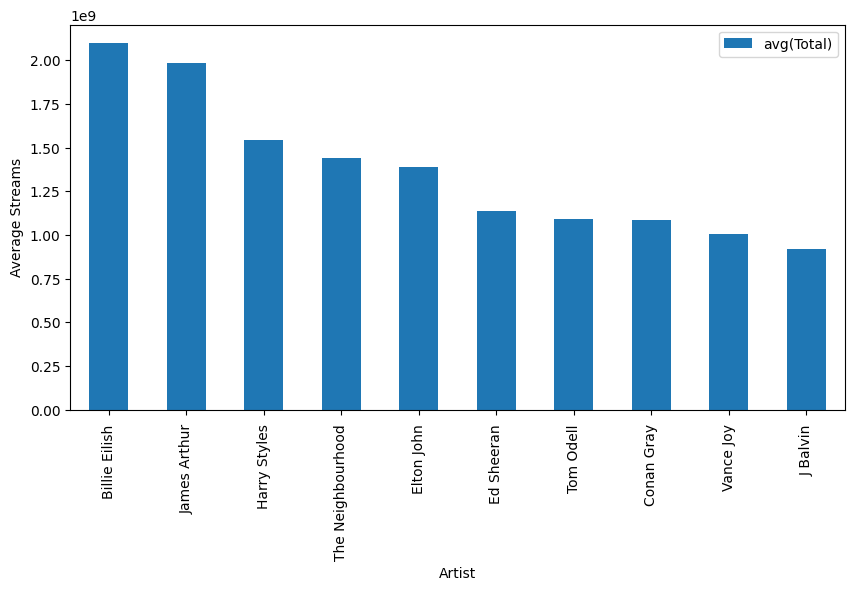

In [37]:
viz_df = (
    df.select("Artist", "Wks", "Total") \
        .groupBy("Artist") \
        .mean() \
        .orderBy("avg(Total)", ascending=False) \
        .toPandas()
)

viz_df.iloc[0:10].plot(
    kind="bar",
    x="Artist",
    y="avg(Total)",
    figsize=(10,5),
    ylabel="Average Streams"
)

In [39]:
# Saving the result
final_data = (
    df.select("Artist", "Wks", "Total") \
        .groupBy("Artist") \
        .mean() \
        .orderBy("avg(Total)", ascending=False) \
)

print(final_data.count())

final_data.show(5)

125
+------------------+--------+--------------------+
|            Artist|avg(Wks)|          avg(Total)|
+------------------+--------+--------------------+
|    Billie Eilish |   254.0|       2.098789064E9|
|     James Arthur |   290.0|       1.983256195E9|
|     Harry Styles |    87.0|1.5457005193333333E9|
|The Neighbourhood |   156.0|       1.440976493E9|
|       Elton John |    81.0|       1.388794442E9|
+------------------+--------+--------------------+
only showing top 5 rows



In [41]:
final_data.write.csv("OutputFiles/spotify_weekly_chart_final_data.csv")
# final_data.write.save("DataFiles/spotify_weekly_chart_final_data.json", format="json")

## Data Preprocessing

1. Categorical Encoding - StringIndexer()
2. Assembling features - VectorAssembler()
3. Scaling - StandardScaler()

In [42]:
# Categorical Encoding
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Artist", outputCol="Encoded_Artist") \
            .fit(final_data)

encoded_df = indexer.transform(final_data)
encoded_df.show(5)

+------------------+--------+--------------------+--------------+
|            Artist|avg(Wks)|          avg(Total)|Encoded_Artist|
+------------------+--------+--------------------+--------------+
|    Billie Eilish |   254.0|       2.098789064E9|           8.0|
|     James Arthur |   290.0|       1.983256195E9|          42.0|
|     Harry Styles |    87.0|1.5457005193333333E9|          34.0|
|The Neighbourhood |   156.0|       1.440976493E9|         108.0|
|       Elton John |    81.0|       1.388794442E9|          26.0|
+------------------+--------+--------------------+--------------+
only showing top 5 rows



In [43]:
# Assembling Vectors
from pyspark.ml.feature import VectorAssembler

assemble = VectorAssembler(
    inputCols=["Encoded_Artist", "avg(Wks)", "avg(Total)"],
    outputCol="Independent features")

assembled_data = assemble.transform(encoded_df)
assembled_data.show(5)

+------------------+--------+--------------------+--------------+--------------------+
|            Artist|avg(Wks)|          avg(Total)|Encoded_Artist|Independent features|
+------------------+--------+--------------------+--------------+--------------------+
|    Billie Eilish |   254.0|       2.098789064E9|           8.0|[8.0,254.0,2.0987...|
|     James Arthur |   290.0|       1.983256195E9|          42.0|[42.0,290.0,1.983...|
|     Harry Styles |    87.0|1.5457005193333333E9|          34.0|[34.0,87.0,1.5457...|
|The Neighbourhood |   156.0|       1.440976493E9|         108.0|[108.0,156.0,1.44...|
|       Elton John |    81.0|       1.388794442E9|          26.0|[26.0,81.0,1.3887...|
+------------------+--------+--------------------+--------------+--------------------+
only showing top 5 rows



In [44]:
# Scaling
from pyspark.ml.feature import StandardScaler

scale = StandardScaler(inputCol="Independent features", outputCol="Scaled Features")
scaled_data = scale.fit(assembled_data)
scaled_data_output = scaled_data.transform(assembled_data)
scaled_data_output.show(5)

+------------------+--------+--------------------+--------------+--------------------+--------------------+
|            Artist|avg(Wks)|          avg(Total)|Encoded_Artist|Independent features|     Scaled Features|
+------------------+--------+--------------------+--------------+--------------------+--------------------+
|    Billie Eilish |   254.0|       2.098789064E9|           8.0|[8.0,254.0,2.0987...|[0.22082097898955...|
|     James Arthur |   290.0|       1.983256195E9|          42.0|[42.0,290.0,1.983...|[1.15931013969515...|
|     Harry Styles |    87.0|1.5457005193333333E9|          34.0|[34.0,87.0,1.5457...|[0.93848916070560...|
|The Neighbourhood |   156.0|       1.440976493E9|         108.0|[108.0,156.0,1.44...|[2.98108321635897...|
|       Elton John |    81.0|       1.388794442E9|          26.0|[26.0,81.0,1.3887...|[0.71766818171604...|
+------------------+--------+--------------------+--------------+--------------------+--------------------+
only showing top 5 rows



## K Means Clustering

In [45]:
from pyspark.ml.clustering import KMeans

KMeans_model = KMeans(featuresCol="Scaled Features", k=4)
KMeans_fit = KMeans_model.fit(scaled_data_output)
KMeans_pred = KMeans_fit.transform(scaled_data_output)

KMeans_pred.show(5)

23/12/17 13:27:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+------------------+--------+--------------------+--------------+--------------------+--------------------+----------+
|            Artist|avg(Wks)|          avg(Total)|Encoded_Artist|Independent features|     Scaled Features|prediction|
+------------------+--------+--------------------+--------------+--------------------+--------------------+----------+
|    Billie Eilish |   254.0|       2.098789064E9|           8.0|[8.0,254.0,2.0987...|[0.22082097898955...|         3|
|     James Arthur |   290.0|       1.983256195E9|          42.0|[42.0,290.0,1.983...|[1.15931013969515...|         3|
|     Harry Styles |    87.0|1.5457005193333333E9|          34.0|[34.0,87.0,1.5457...|[0.93848916070560...|         1|
|The Neighbourhood |   156.0|       1.440976493E9|         108.0|[108.0,156.0,1.44...|[2.98108321635897...|         3|
|       Elton John |    81.0|       1.388794442E9|          26.0|[26.0,81.0,1.3887...|[0.71766818171604...|         1|
+------------------+--------+-------------------

## Visualizing Predictions

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

viz_df2 = KMeans_pred.select(
    "avg(Total)", "avg(Wks)", "prediction"
).toPandas()

avg_df = viz_df2.groupby(["prediction"], as_index=False).mean()
avg_df

,prediction,avg(Total),avg(Wks)
0,0,2.461631e+08,20.085849
1,1,8.261434e+08,75.276812
2,2,1.496832e+08,14.714815
3,3,1.631691e+09,234.500000


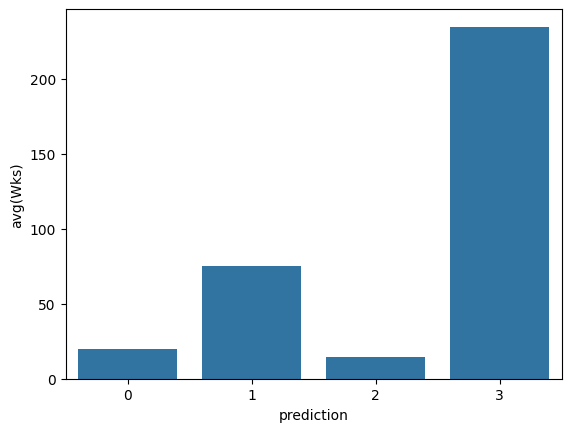

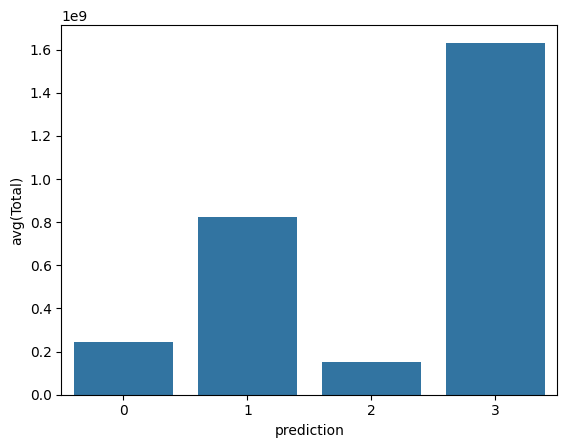

In [56]:
list1 = ["avg(Wks)", "avg(Total)"]

for i in list1:
    sns.barplot(x="prediction", y=str(i), data=avg_df)
    plt.show()